##### Multi-armed Bandits

After letting this algorithm loose on the visitors to a site for a long time, you’ll see that it works by oscillating between (A) exploiting the best option that it currently knows about and (B) exploring at random among all of the options available to it. In fact, you know from the definition of the algorithm that:

    - With probability 1 – epsilon, the epsilon-Greedy algorithm exploits the best known option.
    
    - With probability epsilon / 2, the epsilon-Greedy algorithm explores the best known option.
    
    - With probability epsilon / 2, the epsilon-Greedy algorithm explores the worst known option.
    
A reward is simply a measure of success: it might tell us whether a customer clicked on an ad or signed up as a user. What matters is simply that (A) a reward is something quantitative that we can keep of track of mathematically and that (B) larger amounts of reward are better than smaller amounts.

    - We’re facing a complicated slot machine, called a bandit, that has a set of N arms that we can pull on.
    
    - When pulled, any given arm will output a reward. But these rewards aren’t reliable, which is why we’re gambling: Arm 1 might give us 1 unit of reward only 1% of the time, while Arm 2 might give us 1 unit of reward only 3% of the time. Any specific pull of any specific arm is risky.
    
    - Not only is each pull of an arm risky, we also don’t start off knowing what the reward rates are for any of the arms. We have to figure this out experimentally by actually pulling on the unknown arms.
    
So far the problem we’ve described in just a problem in statistics: you need to cope with risk by figuring out which arm has the highest average reward. You can calculate the average reward by pulling on each arm a lot of times and computing the mean of the rewards you get back. But a real bandit problem is more complicated and also more realistic.

What makes a bandit problem special is that we only receive a small amount of the information about the rewards from each arm. Specifically:

    - We only find out about the reward that was given out by the arm we actually pulled. Whichever arm we pull, we miss out on information about the other arms that we didn’t pull. 
    
    - In fact, the situation is worse than that. Not only do we get only partial feedback about the wisdom of our past decisions, we’re literally falling behind every time we don’t make a good decision: Every time we experiment with an arm that isn’t the best arm, we lose reward because we could, at least in principle, have pulled on a better arm.
    
The full Multiarmed Bandit Problem is defined by the five features above. Any algorithm that offers you a proposed solution to the Multiarmed Bandit Problem must give you a rule for selecting arms in some sequence. And this rule has to balance out your competing desires to (A) learn about new arms and (B) earn as much reward as possible by pulling on arms you already know are good choices.

##### Epsilon-Greedy

epsilon

    - This will be a floating point number that tells us the frequency with which we should explore one of the available arms. If we set epsilon = 0.1, then we’ll explore the available arms on 10% of our pulls.

counts

    - A vector of integers of length N that tells us how many times we’ve played each of the N arms available to us in the current bandit problem. If there are two arms, Arm 1 and Arm 2, which have both been played twice, then we’ll set counts = [2, 2].

values

    - A vector of floating point numbers that defines the average amount of reward we’ve gotten when playing each of the N arms available to us. If Arm 1 gave us 1 unit of reward on one play and 0 on another play, while Arm 2 gave us 0 units of reward on both plays, then we’ll set values = [0.5, 0.0].

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import cm

# random.seed(1)

select_arm

    - Every time we have to make a choice about which arm to pull, we want to be able to simply make a call to our favorite algorithm and have it tell us the numeric name of the arm we should pull.

update

    - After we pull an arm, we get a reward signal back from our system. We want to update our algorithm’s beliefs about the quality of the arm we just chose by providing this reward information. Here, all of the bandit algorithms handle this by providing an update function that takes as arguments 
    
    (1) an algorithm object, 
    (2) the numeric index of the most recently chosen arm and 
    (3) the reward received from choosing that arm. The update method will take this information and make the relevant changes to the algorithm’s evaluation of all of the arms.

In [2]:
# define the epsilon-greedy class

class EpsilonGreedy():
    
    def __init__(self, epsilon, counts, values):
        
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        
        return
    
    def initialize(self, n_arms):
        
        self.counts = np.array([0 for col in range(n_arms)])
        self.values = np.array([0.0 for col in range(n_arms)])
        
        return
    
    def select_arm(self):
        
        if random.random() > self.epsilon:
            
            return np.argmax(self.values)
        
        else:
            
            return random.randrange(len(self.values))
        
    def update(self, chosen_arm, reward):
        
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
    
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
    
        return
        

But there are weaknesses with this approach as well (epsilon = 0.1). 

    - The first weakness is that, as you get more certain which of your two logo designs is best, this tendency to explore the worse design a full 5% of the time will become more wasteful. In the jargon of bandit algorithms, you’ll be over-exploring. 
    
    - And there’s another problem with a fixed 10% exploration rule: at the start of your experimentation, you’ll choose options that you don’t know much about far more rarely than you’d like to because you only try new options 10% of the time.

So there are many ways that the epsilon-Greedy algorithm could be better.

In [3]:
# define the class for a bernoulli arm

class BernoulliArm():
    
    def __init__(self, p):
        
        self.p = p
        
    def draw(self):
        
        if random.random() > self.p:
            
            return 0.0
        
        else:
            
            return 1.0
        

In [4]:
# initialization

means = [0.100, 0.098]

n_arms = len(means)

# random.shuffle(means)

arms = list(map(lambda x: BernoulliArm(x), means))


In [5]:
# define the function to test the algorithm

def test_algorithm(algorithm, arms, num_sims, horizon):
    
    chosen_arms = np.array([[0.0 for j in range(horizon)] for i in range(num_sims)])
    
    rewards = np.array([[0.0 for j in range(horizon)] for i in range(num_sims)])
    
    cumulative_rewards = np.array([[0.0 for j in range(horizon)] for i in range(num_sims)])
    
    sim_nums = np.array([[0.0 for j in range(horizon)] for i in range(num_sims)])
    
    times = np.array([[0.0 for j in range(horizon)] for i in range(num_sims)])
    
    for sim in range(num_sims):
        
        sim = sim + 1
        
        algorithm.initialize(len(arms))

        for t in range(horizon):
            
            t = t + 1
            
            sim_nums[sim - 1, t - 1] = sim
            times[sim - 1, t - 1] = t
            
            chosen_arm = algorithm.select_arm()
            chosen_arms[sim - 1, t - 1] = chosen_arm
            
            reward = arms[int(chosen_arms[sim - 1, t - 1])].draw()
            rewards[sim - 1, t - 1] = reward
            
            if t == 1:
                cumulative_rewards[sim - 1, t - 1] = reward
                
            else:
                cumulative_rewards[sim - 1, t - 1] = cumulative_rewards[sim - 1, t - 2] + reward
                
            algorithm.update(chosen_arm, reward)
            
    return np.array([sim_nums, times, chosen_arms, rewards, cumulative_rewards])

In [6]:
# test the algorithm

algorithm = EpsilonGreedy(0.3, [], [])

algorithm.initialize(n_arms)

results = test_algorithm(algorithm, arms, 500, 1000)

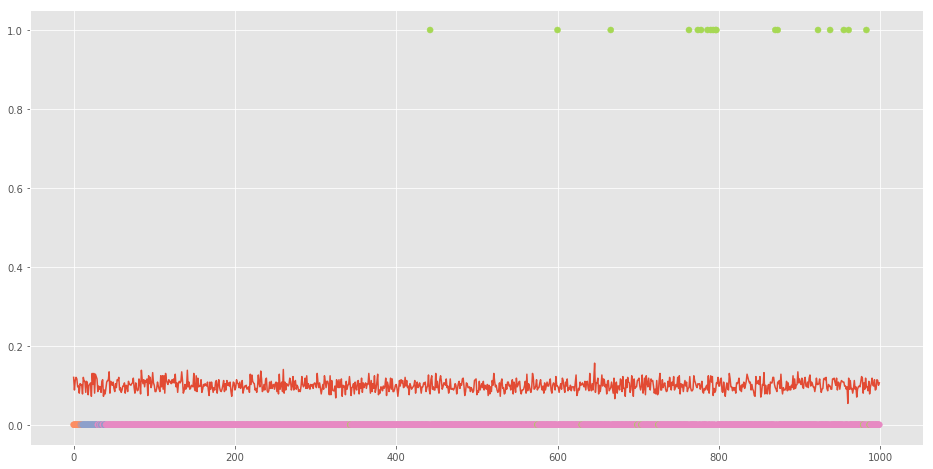

In [7]:
# plot the results

plt.style.use('ggplot')

plt.figure(figsize = (16, 8))

plt.plot(range(1000), np.mean(results[3], axis = 0))

plt.scatter(range(1000), np.mean(results[2], axis = 0) > 0.5, c = cm.Set2(np.mean(results[2], axis = 0)))

plt.show()